In [41]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from random import randint

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#SKLEARN?
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

Laden der Daten:

In [42]:
data = pd.read_csv("data_insurance.csv", sep = ";", names = ['age', 'sex', 'bmi', 'children', 'smoker', 'canton', "pbf", 'charges'])
data = data.iloc[1:]

data['charges'] = data['charges'].str.replace("’", "").apply(pd.to_numeric)
data['pbf'] = data['pbf'].apply(pd.to_numeric)
data['bmi'] = data['bmi'].apply(pd.to_numeric)
data['age'] = data['age'].apply(pd.to_numeric)
data['children'] = data['children'].apply(pd.to_numeric)

data = pd.read_csv("data_insurance.csv", sep = ";", names = ['age', 'sex', 'bmi', 'children', 'smoker', 'canton', "pbf", 'charges'])
data = data.iloc[1:]

data['charges'] = data['charges'].str.replace("’", "").apply(pd.to_numeric)
data['pbf'] = data['pbf'].apply(pd.to_numeric)
data['bmi'] = data['bmi'].apply(pd.to_numeric)
data['age'] = data['age'].apply(pd.to_numeric)
data['children'] = data['children'].apply(pd.to_numeric)

# 1 record with negative percentage of body fat.
data = data[data["pbf"]>0]
data = data.dropna()
print(data)

      age sex     bmi  children smoker canton    pbf  charges
1      19   w  24.720         0     ja     SO  35.94     4253
2      18   m  29.416         1   nein     AG  26.86     2494
3      28   m  28.800         3   nein     AG  26.92     3138
4      33   m  20.564         0   nein     BS   7.98     1553
5      32   m  25.504         0   nein     BS  21.84     2768
...   ...  ..     ...       ...    ...    ...    ...      ...
1334   50   m  27.176         3   nein     BS  23.02     5767
1335   18   w  27.936         0   nein     BL  42.18     2547
1336   18   w  31.880         0   nein     AG  49.59     3026
1337   21   w  23.040         0   nein     SO  31.18     2208
1338   61   w  25.656         0     ja     BS  38.63    19007

[1337 rows x 8 columns]


In [43]:
#index are not correct, don't know why, removed entries manually
children_outliers_to_del = data[(data['age'] <= 21) & (data['children'] == 5)].index.values - 1

for i in children_outliers_to_del:
    print(i)

#when these are removed, the score is worse by .10 for some reason but the mean absolute error drops by 60 points
data2 = data.drop(data.index[[32, 165, 983]])
data2[(data2['age'] <= 21) & (data2['children'] == 5)]

charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
for i in charges_outliers_to_del:
    print(i)

data_no_outliers = data2.drop(data.index[[542]])

data_no_outliers[(data['charges'] >= 59000)]

32
166
984
543


<ipython-input-43-b47d867cebb1>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
<ipython-input-43-b47d867cebb1>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_no_outliers[(data['charges'] >= 59000)]


,age,sex,bmi,children,smoker,canton,pbf,charges


In [44]:
data_trees_no_outliers = data_no_outliers.copy()

# Encode categorical variables.
data_no_outliers["sex"] = pd.factorize(data_no_outliers['sex'])[0]
data_no_outliers["smoker"] = pd.factorize(data_no_outliers['smoker'])[0]
data_no_outliers['canton'] = pd.factorize(data_no_outliers['canton'])[0]

# Encode categorical variables.
data_trees_no_outliers["female"] = data_trees_no_outliers["sex"] == "w"
data_trees_no_outliers["male"] = data_trees_no_outliers["sex"] == "m"
data_trees_no_outliers["smoker"] = data_trees_no_outliers["smoker"].apply(lambda x: x=="ja")

for canton_name in data_trees_no_outliers["canton"].unique():
    data_trees_no_outliers[canton_name.lower()] = data_trees_no_outliers["canton"] == canton_name

# Remove encoded categorical variables.
data_trees_no_outliers = data_trees_no_outliers.drop('sex', axis=1)
data_trees_no_outliers = data_trees_no_outliers.drop('canton', axis=1)


# Divide the charges into categories. Is there a more objective way to determine the categories? K-clustering?
bins = [1, 10000, 29000, 1000000]
bin_labels = [0, 1, 2]
data_trees_no_outliers["charges_level"] = pd.cut(data_trees_no_outliers["charges"], bins=bins, labels=bin_labels, include_lowest=True)
data_no_outliers["charges_level"] = pd.cut(data_no_outliers["charges"], bins=bins, labels=bin_labels, include_lowest=True)

random_seed = randint(0,100)

print(data_no_outliers.head())

print(data_trees_no_outliers.head())

   age  sex     bmi  children  smoker  canton    pbf  charges charges_level
1   19    0  24.720         0       0       0  35.94     4253             0
2   18    1  29.416         1       1       1  26.86     2494             0
3   28    1  28.800         3       1       1  26.92     3138             0
4   33    1  20.564         0       1       2   7.98     1553             0
5   32    1  25.504         0       1       2  21.84     2768             0
   age     bmi  children  smoker    pbf  charges  female   male     so     ag  \
1   19  24.720         0    True  35.94     4253    True  False   True  False   
2   18  29.416         1   False  26.86     2494   False   True  False   True   
3   28  28.800         3   False  26.92     3138   False   True  False   True   
4   33  20.564         0   False   7.98     1553   False   True  False  False   
5   32  25.504         0   False  21.84     2768   False   True  False  False   

      bs     bl charges_level  
1  False  False          

In [45]:
labels = np.array(data_no_outliers['charges'])
# The data we want to split = 'input'
input = data_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1).drop('sex', axis = 1).drop('children', axis = 1).drop('canton', axis = 1)

# The argument for the split function has to be an array
input = np.array(input)

# Split the data into training and test sets
train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.25, random_state = random_seed) 

labels_trees = np.array(data_trees_no_outliers['charges'])
# The data we want to split = 'input'

input_trees = data_trees_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1).drop('female', axis = 1).drop('male', axis = 1).drop('children', axis = 1).drop('so', axis = 1).drop('ag', axis = 1).drop('bs', axis = 1).drop('bl', axis = 1)

# The argument for the split function has to be an array
input_trees = np.array(input_trees)

# Split the data into training and test sets
train_input_trees, test_input_trees, train_labels_trees, test_labels_trees = \
    train_test_split(input_trees, labels_trees, test_size = 0.25, random_state = random_seed) 

#### Linear Regression Confusion Matrix with a Base Model (Alpha = 0)

Its output was converted to match the categorical buckets.

[[29.    18.588  1.    27.37 ]
 [52.    38.16   1.    61.5  ]
 [24.    25.2    1.    20.36 ]
 ...
 [19.    26.6    0.    21.73 ]
 [56.    31.04   1.    48.04 ]
 [48.    26.56   1.    21.76 ]]


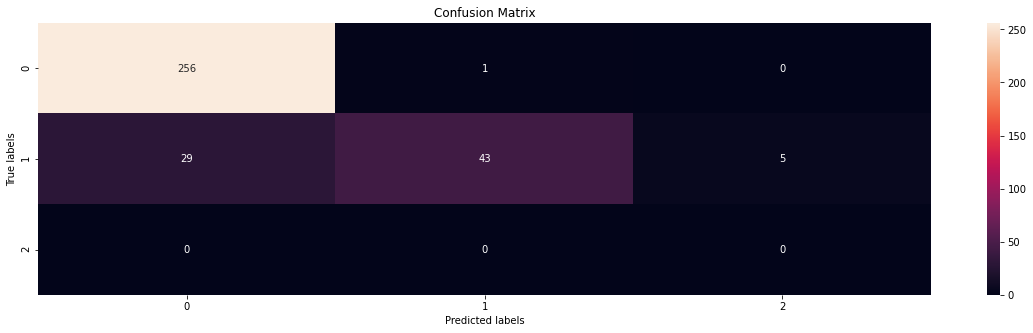

              precision    recall  f1-score   support

           0       1.00      0.90      0.94       285
           1       0.56      0.98      0.71        44
           2       0.00      0.00      0.00         5

    accuracy                           0.90       334
   macro avg       0.52      0.63      0.55       334
weighted avg       0.92      0.90      0.90       334



C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print(train_input)
# define model
ridge_model = Ridge(alpha=0)
# fit model
ridge_model.fit(train_input, train_labels)

predics = ridge_model.predict(test_input)

bins = [1, 10000, 29000, 1000000]

predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)

cm = confusion_matrix(predics_categorized, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

#logistic_regression.score(X_test, y_test)
#plot_confusion_matrix(logistic_regression, X_test, y_test, display_labels = y_labels)
print(classification_report(test_labels_categorized, predics_categorized))

These are the confusion matrix results for 

#### Logistic Regression using extended dataframe that's used for random forest as well

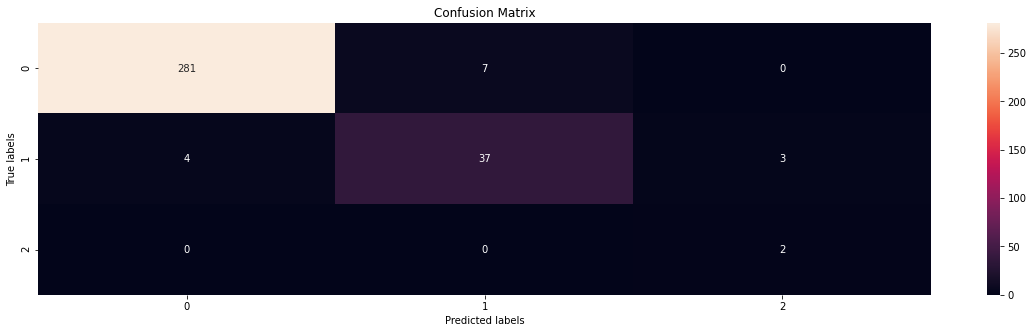

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.84      0.84      0.84        44
           2       1.00      0.40      0.57         5

    accuracy                           0.96       334
   macro avg       0.94      0.74      0.80       334
weighted avg       0.96      0.96      0.96       334



In [68]:
logistic_regression = LogisticRegression(max_iter = 10000)
train_labels_categorized = pd.cut(abs(train_labels_trees), bins=bins, labels=bin_labels, include_lowest=True)
logistic_regression.fit(train_input_trees, train_labels_categorized)

label_prediction = logistic_regression.predict(test_input_trees)

cm = confusion_matrix(label_prediction, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(test_labels_categorized, label_prediction))

#### Logistic Regression using same dataframe as in Ridge Regression

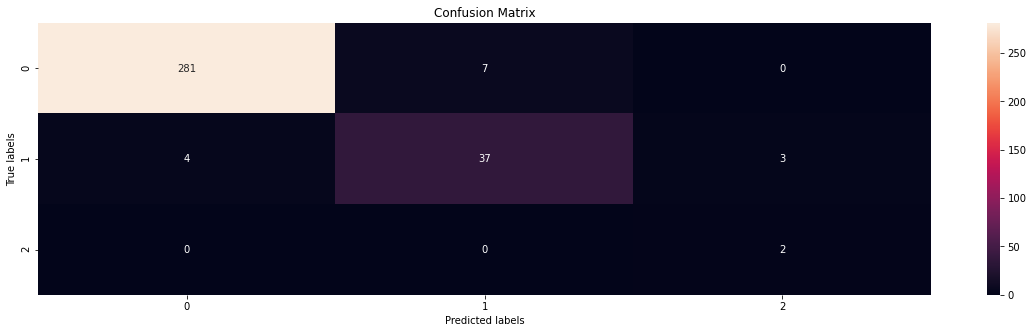

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.84      0.84      0.84        44
           2       1.00      0.40      0.57         5

    accuracy                           0.96       334
   macro avg       0.94      0.74      0.80       334
weighted avg       0.96      0.96      0.96       334



In [66]:
logistic_regression = LogisticRegression(max_iter = 10000)
train_labels_categorized = pd.cut(abs(train_labels), bins=bins, labels=bin_labels, include_lowest=True)
logistic_regression.fit(train_input, train_labels_categorized)

label_prediction = logistic_regression.predict(test_input)

cm = confusion_matrix(label_prediction, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(test_labels_categorized, label_prediction))

#### Decision Trees

(999, 4)


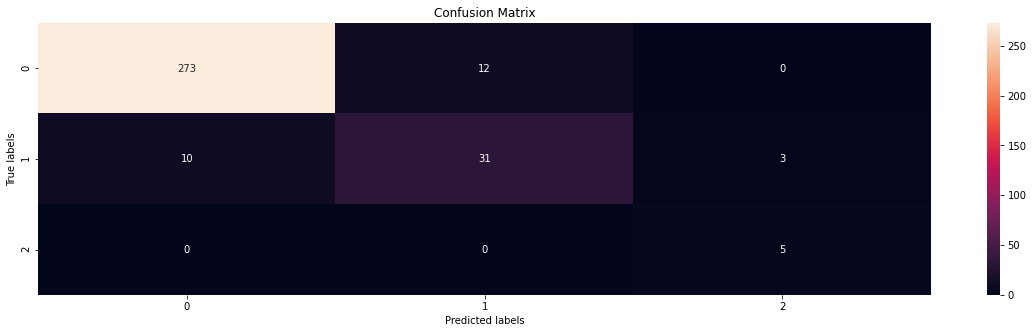

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       285
           1       0.72      0.70      0.71        44
           2       0.62      1.00      0.77         5

    accuracy                           0.93       334
   macro avg       0.77      0.89      0.81       334
weighted avg       0.93      0.93      0.93       334



In [56]:
model = DecisionTreeClassifier()
fitted = model.fit(train_input_trees, train_labels_trees)
print(train_input_trees.shape)
# Round up prediction labels as integers
label_prediction = model.predict(test_input_trees)

result = pd.DataFrame()
result['prediction'] = label_prediction
result['prediction_charges_level'] = pd.cut(result['prediction'],
                                            bins=bins, # use bins from before
                                            labels=bin_labels, 
                                            include_lowest=True)

result['actual'] = test_labels
result['actual_charges_level'] = pd.cut(result['actual'], 
                                        bins=bins, 
                                        labels=bin_labels, 
                                        include_lowest=True)


cm = confusion_matrix(result["actual_charges_level"], result["prediction_charges_level"])

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(result["actual_charges_level"], result["prediction_charges_level"]))

#### Optimized Ridge Regression

[[-0.57735027 -0.57735027 -0.57735027]
 [-0.57533275  0.78940751 -0.21407476]
 [-0.57936076 -0.2085724   0.78793316]]
[[26.         14.66885221  3.          1.          3.          8.84775234]
 [39.         19.93501684  0.          1.          3.         23.0344368 ]
 [51.         14.64843304  3.          1.          2.         31.87941582]
 ...
 [36.         15.58298658  0.          1.          1.         10.78665485]
 [54.         13.28045492  1.          1.          3.         28.00112049]
 [48.         14.62450803  0.          1.          2.         32.39055034]]


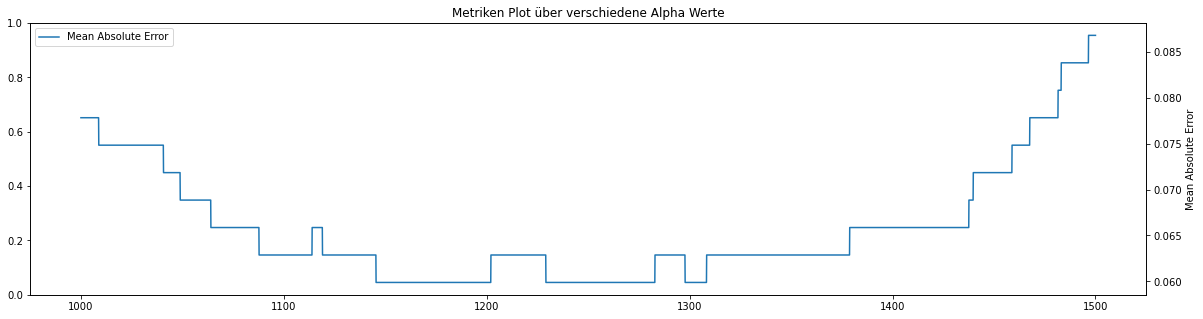

Mean Absolute Error min value: 0.059880239520958084
Alpha value for Mean Absolute Error min value: 1145.4145414541454


In [71]:
pca_data = data_no_outliers[['sex','bmi', 'pbf']]

X = pca_data.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print(components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

data4 = data_no_outliers.copy()
data4[['sex','bmi', 'pbf']] = np.dot(data4[['sex', 'bmi', 'pbf']].values, components_.T)

labels = np.array(data_no_outliers['charges'])

# The data we want to split = 'input'
input = data4.drop('sex', axis=1).drop('charges', axis = 1).drop('charges_level', axis = 1)

# The argument for the split function has to be an array
input = np.array(input)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.25, random_state = 42) 
train_input = np.array(train_input, dtype=np.float64)
test_input = np.array(test_input, dtype=np.float64)
print(test_input)
train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)


maeArray = []

alphaRange = np.linspace(1000, 1500, 10000)
for i in alphaRange:  
    RidgeRegressor = Ridge(alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)
    predics = RidgeRegressor.predict(test_input_standardize)
    
    predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
    test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)
    
    
    #print(predics_categorized.to_numpy(), test_labels_categorized.to_numpy())
    #print(i)
    try:
        mae = mean_absolute_error(test_labels_categorized.to_numpy(),  predics_categorized.to_numpy())
    except ValueError:
        print("Oops!  That was no valid number.  Try again...", ValueError)
    maeArray.append(mae)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])

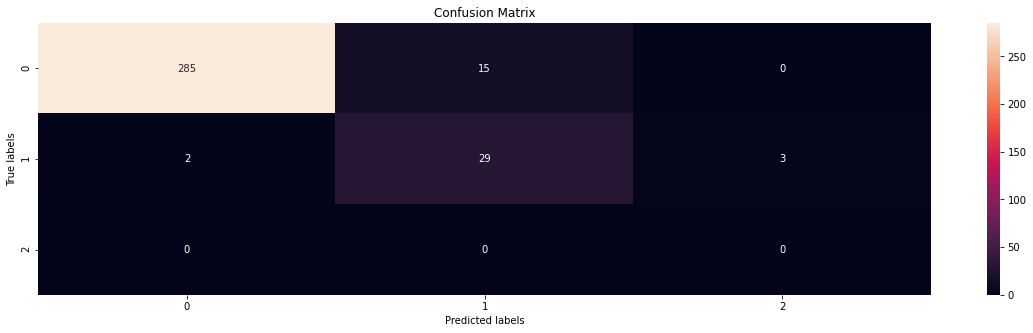

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       287
           1       0.85      0.66      0.74        44
           2       0.00      0.00      0.00         3

    accuracy                           0.94       334
   macro avg       0.60      0.55      0.57       334
weighted avg       0.93      0.94      0.93       334



C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
RidgeRegressor = Ridge(alpha = 1145.4145414541454)
ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)
predics = RidgeRegressor.predict(test_input_standardize)

predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)

cm = confusion_matrix(predics_categorized, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

#logistic_regression.score(X_test, y_test)
#plot_confusion_matrix(logistic_regression, X_test, y_test, display_labels = y_labels)
print(classification_report(test_labels_categorized, predics_categorized))

### Discussion

TL/TR: Multiple ways of categorizing costs have been analyzed to see which classifier fits best. Decision Trees win by a slight margin. While they're worse in classifying lower cost patients, they are better for classigying higher cost patients.

The data has been analyzed using multiple simple classifiers. First we cleaned up the data then we used Linear Regression (Later with Ridge Regularization), Logistic Regression and Decision Trees to see which classifier can predict the cost categories of the entries. We tried using the following borders: 1-10000, 10001-39000, 39000+. These borders were taken from the K-means analysis. The last category seemed to have way too few entries and we suggest lowering that border by 10000 to have more training data. So in the end we used 29000 as a border. 

When using Ridge Regression, we tried categorizing its numerical results into 0, 1 and 2. Other classifiers' results were already categorical. While Logistic Regression seemed to be better suited than Linear Regression and even Ridge Regression, both were lacking in correctly classifying the last category. For higher levels (and those are the important ones since we don't want to falsely classify higher cost clients) Trees were slightly better. For the first two categories Linear Regression and Logistic Regression were better than Decision Trees. Do we compromise in the first categories to get better results for higher categories? In the end we will use an ensemble method to combine Trees and Linear Regression because they offer the most transparancy.